In [1]:
from sklearn.preprocessing import MinMaxScaler , StandardScaler , QuantileTransformer , normalize
from sklearn.metrics import r2_score
from keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping , ModelCheckpoint
from keras import metrics, regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
epochs = 3000
tester_units = [0]
shared_units = Volume_units = ema6_units = ema12_units = ema26_units = macd_units = wrsi_units = K_units = D_units = closed_units = 64
batch_size = 256
early_stop = EarlyStopping(monitor='val_dense_9_loss', patience=20)
model_cp = ModelCheckpoint("model_units_"+str(shared_units)+"batch_"+str(batch_size)+".cp",monitor='dense_9_loss',save_best_only=True)
def splitData(X,Y,rate):
    X_train = X[:int(X.shape[0]*rate)]
    Y_train = Y[:int(Y.shape[0]*rate)]
    X_val = X[int(X.shape[0]*rate):]
    Y_val = Y[int(Y.shape[0]*rate)-1:-1]
    return X_train, Y_train, X_val, Y_val

df = pd.read_csv("data/2330_indicators.csv")
df = df.drop('Unnamed: 0',axis=1)
#print(df)

X_train = df.values
y_train = df.loc[1:].values
X_train , Y_train , X_val , Y_val = splitData(X_train,y_train,0.8)
shared_lstm_init = LSTM(shared_units,activation='relu',kernel_initializer='lecun_uniform',kernel_regularizer = regularizers.l2(0.01),return_sequences = True)
shared_lstm1 = LSTM(shared_units,kernel_regularizer=regularizers.l2(0.01),return_sequences=True)
shared_lstm2 = LSTM(shared_units,kernel_regularizer=regularizers.l2(0.01),return_sequences=True)
shared_lstm3 = LSTM(shared_units,kernel_regularizer=regularizers.l2(0.01),return_sequences=False)

Normalization

In [30]:
sc_X = QuantileTransformer()
X_train_sc = sc_X.fit_transform(X_train)
print(X_train.shape)
X_val_sc = sc_X.transform(X_val)
X_train_df = pd.DataFrame(data=X_train_sc)
X_val_df = pd.DataFrame(data=X_val_sc)
sc = MinMaxScaler(feature_range=(np.min(df.loc[:,'closed'].values),np.max(df.loc[:,'closed'].values)))
a = np.array(X_train_df.loc[:,1].values)
a = a.reshape(a.shape[0],1)
b = np.array(X_val_df.loc[:,1].values)
b = b.reshape(b.shape[0],1)
a = sc.fit_transform(a)
b = sc.transform(b)

(5029, 9)


Layer#1 Volume Training

In [4]:
#Volume_X_train = a.reshape(a.shape[0])
Volume_X_train = X_train_df.loc[:,1].values
Volume_Y_train = Volume_X_train[1:]
Volume_X_train = Volume_X_train[:-1]
#Volume_X_val = b.reshape(b.shape[0])
Volume_X_val = X_val_df.loc[:,1].values
Volume_Y_val = Volume_X_val[1:]
Volume_X_val = Volume_X_val[:-1]
Volume_X_train = Volume_X_train.reshape(Volume_X_train.shape[0],1,1)
Volume_X_val = Volume_X_val.reshape(Volume_X_val.shape[0],1,1)
VolumeInput = Input(shape=(1,1))
Volume_model = shared_lstm_init(VolumeInput)
Volume_model = shared_lstm1(Volume_model)
Volume_model = shared_lstm2(Volume_model)
Volume_out = shared_lstm3(Volume_model)
Volume_model = Dense(1)(Volume_out)

Layer#2 ema6

In [5]:
ema6_X_train = X_train_df.loc[:,2].values 
ema6_Y_train = ema6_X_train[1:] 
ema6_X_train = ema6_X_train[:-1]
ema6_X_val = X_val_df.loc[:,2].values
ema6_Y_val = ema6_X_val[1:]
ema6_X_val = ema6_X_val[:-1]
ema6_X_train = ema6_X_train.reshape(ema6_X_train.shape[0],1,1)
ema6_X_val = ema6_X_val.reshape(ema6_X_val.shape[0],1,1)
ema6Input = Input(shape=(1,1))
ema6_model = shared_lstm_init(ema6Input)
ema6_model = shared_lstm1(ema6_model)
ema6_model = shared_lstm2(ema6_model)
ema6_out = shared_lstm3(ema6_model)
ema6_model = Dense(1)(ema6_out)

In [6]:
"""
model = Model(inputs=[VolumeInput,ema6Input],outputs=[Volume_model,ema6_model])
model.compile(loss = 'mean_squared_error',optimizer='Adam')
model.fit([Volume_X_train,ema6_X_train],[Volume_Y_train,ema6_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,callbacks=[early_stop])
#model.fit([Volume_X_train,ema6_X_train],[Volume_Y_train,ema6_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,callbacks=[early_stop])
preds = model.predict([Volume_X_val,ema6_X_val])
r2score = r2_score(Volume_Y_val,preds[0])
plt.plot(preds[0][:100])
plt.plot(Volume_Y_val[:100])
plt.show()
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))
"""

'\nmodel = Model(inputs=[VolumeInput,ema6Input],outputs=[Volume_model,ema6_model])\nmodel.compile(loss = \'mean_squared_error\',optimizer=\'Adam\')\nmodel.fit([Volume_X_train,ema6_X_train],[Volume_Y_train,ema6_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,callbacks=[early_stop])\n#model.fit([Volume_X_train,ema6_X_train],[Volume_Y_train,ema6_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,callbacks=[early_stop])\npreds = model.predict([Volume_X_val,ema6_X_val])\nr2score = r2_score(Volume_Y_val,preds[0])\nplt.plot(preds[0][:100])\nplt.plot(Volume_Y_val[:100])\nplt.show()\nprint("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))\n'

Layer#2 ema12

In [7]:
ema12_X_train = X_train_df.loc[:,3].values
ema12_Y_train = ema12_X_train[1:] 
ema12_X_train = ema12_X_train[:-1]
ema12_X_val = X_val_df.loc[:,3].values 
ema12_Y_val = ema12_X_val[1:]
ema12_X_val = ema12_X_val[:-1]
ema12_X_train = ema12_X_train.reshape(ema12_X_train.shape[0],1,1)
ema12_X_val = ema12_X_val.reshape(ema12_X_val.shape[0],1,1)
ema12Input = Input(shape=(1,1))
ema12_model = shared_lstm_init(ema12Input)
ema12_model = shared_lstm1(ema12_model)
ema12_model = shared_lstm2(ema12_model)
ema12_out = shared_lstm3(ema12_model)
ema12_model = Dense(1,activation='relu')(ema12_out)
print(ema12_X_val.shape,ema12_Y_val.shape)

(1257, 1, 1) (1257,)


In [8]:
ema26_X_train = X_train_df.loc[:,4].values 
ema26_Y_train = ema26_X_train[1:] 
ema26_X_train = ema26_X_train[:-1]
ema26_X_val = X_val_df.loc[:,4].values
ema26_Y_val = ema26_X_val[1:]
ema26_X_val = ema26_X_val[:-1]
ema26_X_train = ema26_X_train.reshape(ema26_X_train.shape[0],1,1)
ema26_X_val = ema26_X_val.reshape(ema26_X_val.shape[0],1,1)
ema26Input = Input(shape=(1,1))
ema26_model = shared_lstm_init(ema26Input)
ema26_model = shared_lstm1(ema26_model)
ema26_model = shared_lstm2(ema26_model)
ema26_out = shared_lstm3(ema26_model)
ema26_model = Dense(1,activation='relu')(ema26_out)
print(ema26_X_val.shape,ema26_Y_val.shape)

(1257, 1, 1) (1257,)


In [9]:
macd_X_train = X_train_df.loc[:,5].values 
macd_Y_train = macd_X_train[1:] 
macd_X_train = macd_X_train[:-1]
macd_X_val = X_val_df.loc[:,5].values 
macd_Y_val = macd_X_val[1:]
macd_X_val = macd_X_val[:-1]
macd_X_train = macd_X_train.reshape(macd_X_train.shape[0],1,1)
macd_X_val = macd_X_val.reshape(macd_X_val.shape[0],1,1)
macdInput = Input(shape=(1,1))
macd_model = shared_lstm_init(macdInput)
macd_model = shared_lstm1(macd_model)
macd_model = shared_lstm2(macd_model)
macd_out = shared_lstm3(macd_model)
macd_model = Dense(1,activation='relu')(macd_out)

In [10]:
wrsi_X_train = X_train_df.loc[:,6].values 
wrsi_Y_train = wrsi_X_train[1:] 
wrsi_X_train = wrsi_X_train[:-1]
wrsi_X_val = X_val_df.loc[:,6].values 
wrsi_Y_val = wrsi_X_val[1:]
wrsi_X_val = wrsi_X_val[:-1]
wrsi_X_train = wrsi_X_train.reshape(wrsi_X_train.shape[0],1,1)
wrsi_X_val = wrsi_X_val.reshape(wrsi_X_val.shape[0],1,1)
wrsiInput = Input(shape=(1,1))
wrsi_model = shared_lstm_init(wrsiInput)
wrsi_model = shared_lstm1(wrsi_model)
wrsi_model = shared_lstm2(wrsi_model)
wrsi_out = shared_lstm3(wrsi_model)
wrsi_model = Dense(1,activation='relu')(wrsi_out)
print(wrsi_X_val.shape,wrsi_Y_val.shape)

(1257, 1, 1) (1257,)


In [11]:
K_X_train = X_train_df.loc[:,7].values
K_Y_train = K_X_train[1:] 
K_X_train = K_X_train[:-1]
K_X_val = X_val_df.loc[:,7].values
K_Y_val = K_X_val[1:]
K_X_val = K_X_val[:-1]
K_X_train = K_X_train.reshape(K_X_train.shape[0],1,1)
K_X_val = K_X_val.reshape(K_X_val.shape[0],1,1)
KInput = Input(shape=(1,1))
K_model = shared_lstm_init(KInput)
K_model = shared_lstm1(K_model)
K_model = shared_lstm2(K_model)
K_out = shared_lstm3(K_model)
K_model = Dense(1,activation='relu')(K_out)
print(K_X_val.shape,K_Y_val.shape)

(1257, 1, 1) (1257,)


In [12]:
D_X_train = X_train_df.loc[:,8].values
D_Y_train = D_X_train[1:] 
D_X_train = D_X_train[:-1]
D_X_val = X_val_df.loc[:,8].values 
D_Y_val = D_X_val[1:]
D_X_val = D_X_val[:-1]
D_X_train = D_X_train.reshape(D_X_train.shape[0],1,1)
D_X_val = D_X_val.reshape(D_X_val.shape[0],1,1)
DInput = Input(shape=(1,1))
D_model = shared_lstm_init(DInput)
D_model = shared_lstm1(D_model)
D_model = shared_lstm2(D_model)
D_out = shared_lstm3(D_model)
D_model = Dense(1,activation='relu')(D_out)
print(D_X_val.shape,D_Y_val.shape)

(1257, 1, 1) (1257,)


In [13]:
closed_X_train = X_train_df.loc[:,0].values 
closed_Y_train = closed_X_train[1:] 
closed_X_train = closed_X_train[:-1]
closed_X_val = X_val_df.loc[:,0].values 
closed_Y_val = closed_X_val[1:]
closed_X_val = closed_X_val[:-1]
closed_X_train = closed_X_train.reshape(closed_X_train.shape[0],1,1)
closed_X_val = closed_X_val.reshape(closed_X_val.shape[0],1,1)
closedInput = Input(shape=(1,1))
#closed_model = Concatenate([Volume_out,ema6_out,ema12_out,ema26_out,macd_out,wrsi_out,K_out,D_out,closedInput])
closed_model = shared_lstm_init(closedInput)
closed_model = shared_lstm1(closed_model)
closed_model = shared_lstm2(closed_model)
closed_out = shared_lstm3(closed_model)
closed_model = Dense(1,activation='relu')(closed_out)
inputs=[VolumeInput,ema6Input,ema12Input,ema26Input,macdInput,wrsiInput,KInput,DInput,closedInput]
outputs=[Volume_model,ema6_model,ema12_model,ema26_model,macd_model,wrsi_model,K_model,D_model,closed_model]
shared_units = 64
merged_model = Model(inputs=[VolumeInput,ema6Input,ema12Input,ema26Input,macdInput,wrsiInput,KInput,DInput,closedInput],outputs=[Volume_model,ema6_model,ema12_model,ema26_model,macd_model,wrsi_model,K_model,D_model,closed_model])
merged_model.summary()
merged_model.compile(loss='mean_squared_error',optimizer='Adam')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
input_5 (I

In [14]:

history = merged_model.fit([Volume_X_train,ema6_X_train,ema12_X_train,ema26_X_train,macd_X_train,wrsi_X_train,K_X_train,D_X_train,closed_X_train],[Volume_Y_train,ema6_Y_train,ema12_Y_train,ema26_Y_train,macd_Y_train,wrsi_Y_train,K_Y_train,D_Y_train,closed_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,validation_data=([Volume_X_val,ema6_X_val,ema12_X_val,ema26_X_val,macd_X_val,wrsi_X_val,K_X_val,D_X_val,closed_X_val],[Volume_Y_val,ema6_Y_val,ema12_Y_val,ema26_Y_val,macd_Y_val,wrsi_Y_val,K_Y_val,D_Y_val,closed_Y_val]),callbacks=[early_stop,model_cp])

Train on 5028 samples, validate on 1257 samples
Epoch 1/3000
5028/5028 [==============================] - 30s 6ms/step - loss: 7.8925 - dense_1_loss: 0.3127 - dense_2_loss: 0.3187 - dense_3_loss: 0.3157 - dense_4_loss: 0.3207 - dense_5_loss: 0.3109 - dense_6_loss: 0.3150 - dense_7_loss: 0.3117 - dense_8_loss: 0.3115 - dense_9_loss: 0.3173 - val_loss: 9.2783 - val_dense_1_loss: 0.1951 - val_dense_2_loss: 0.8121 - val_dense_3_loss: 0.7957 - val_dense_4_loss: 0.8187 - val_dense_5_loss: 0.3930 - val_dense_6_loss: 0.3188 - val_dense_7_loss: 0.3415 - val_dense_8_loss: 0.3476 - val_dense_9_loss: 0.8074
Epoch 2/3000
5028/5028 [==============================] - 2s 378us/step - loss: 6.3346 - dense_1_loss: 0.2462 - dense_2_loss: 0.2700 - dense_3_loss: 0.2553 - dense_4_loss: 0.2738 - dense_5_loss: 0.2408 - dense_6_loss: 0.2535 - dense_7_loss: 0.2423 - dense_8_loss: 0.2426 - dense_9_loss: 0.2642 - val_loss: 7.1473 - val_dense_1_loss: 0.1216 - val_dense_2_loss: 0.6278 - val_dense_3_loss: 0.5675 - v

Epoch 16/3000
5028/5028 [==============================] - 2s 373us/step - loss: 1.8277 - dense_1_loss: 0.0403 - dense_2_loss: 0.0032 - dense_3_loss: 0.0028 - dense_4_loss: 0.0032 - dense_5_loss: 0.0027 - dense_6_loss: 0.0281 - dense_7_loss: 0.0107 - dense_8_loss: 0.0061 - dense_9_loss: 0.0033 - val_loss: 1.8116 - val_dense_1_loss: 0.0357 - val_dense_2_loss: 0.0083 - val_dense_3_loss: 0.0071 - val_dense_4_loss: 0.0085 - val_dense_5_loss: 0.0040 - val_dense_6_loss: 0.0314 - val_dense_7_loss: 0.0122 - val_dense_8_loss: 0.0066 - val_dense_9_loss: 0.0076
Epoch 17/3000
5028/5028 [==============================] - 2s 370us/step - loss: 1.7682 - dense_1_loss: 0.0403 - dense_2_loss: 0.0030 - dense_3_loss: 0.0026 - dense_4_loss: 0.0030 - dense_5_loss: 0.0026 - dense_6_loss: 0.0281 - dense_7_loss: 0.0106 - dense_8_loss: 0.0059 - dense_9_loss: 0.0031 - val_loss: 1.7536 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 0.0081 - val_dense_3_loss: 0.0070 - val_dense_4_loss: 0.0083 - val_dense_5_loss: 0

Epoch 31/3000
5028/5028 [==============================] - 2s 374us/step - loss: 1.1394 - dense_1_loss: 0.0415 - dense_2_loss: 0.0024 - dense_3_loss: 0.0023 - dense_4_loss: 0.0024 - dense_5_loss: 0.0029 - dense_6_loss: 0.0286 - dense_7_loss: 0.0111 - dense_8_loss: 0.0063 - dense_9_loss: 0.0026 - val_loss: 1.1280 - val_dense_1_loss: 0.0352 - val_dense_2_loss: 0.0062 - val_dense_3_loss: 0.0058 - val_dense_4_loss: 0.0068 - val_dense_5_loss: 0.0023 - val_dense_6_loss: 0.0306 - val_dense_7_loss: 0.0109 - val_dense_8_loss: 0.0052 - val_dense_9_loss: 0.0061
Epoch 32/3000
5028/5028 [==============================] - 2s 379us/step - loss: 1.1052 - dense_1_loss: 0.0415 - dense_2_loss: 0.0023 - dense_3_loss: 0.0023 - dense_4_loss: 0.0023 - dense_5_loss: 0.0030 - dense_6_loss: 0.0286 - dense_7_loss: 0.0111 - dense_8_loss: 0.0063 - dense_9_loss: 0.0026 - val_loss: 1.0937 - val_dense_1_loss: 0.0352 - val_dense_2_loss: 0.0060 - val_dense_3_loss: 0.0056 - val_dense_4_loss: 0.0066 - val_dense_5_loss: 0

Epoch 46/3000
5028/5028 [==============================] - 2s 373us/step - loss: 0.7263 - dense_1_loss: 0.0413 - dense_2_loss: 0.0018 - dense_3_loss: 0.0017 - dense_4_loss: 0.0018 - dense_5_loss: 0.0025 - dense_6_loss: 0.0285 - dense_7_loss: 0.0107 - dense_8_loss: 0.0058 - dense_9_loss: 0.0021 - val_loss: 0.7189 - val_dense_1_loss: 0.0353 - val_dense_2_loss: 0.0044 - val_dense_3_loss: 0.0043 - val_dense_4_loss: 0.0050 - val_dense_5_loss: 0.0017 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0106 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0045
Epoch 47/3000
5028/5028 [==============================] - 2s 377us/step - loss: 0.7051 - dense_1_loss: 0.0412 - dense_2_loss: 0.0017 - dense_3_loss: 0.0017 - dense_4_loss: 0.0018 - dense_5_loss: 0.0024 - dense_6_loss: 0.0284 - dense_7_loss: 0.0107 - dense_8_loss: 0.0058 - dense_9_loss: 0.0021 - val_loss: 0.6984 - val_dense_1_loss: 0.0353 - val_dense_2_loss: 0.0044 - val_dense_3_loss: 0.0042 - val_dense_4_loss: 0.0049 - val_dense_5_loss: 0

Epoch 61/3000
5028/5028 [==============================] - 2s 367us/step - loss: 0.4707 - dense_1_loss: 0.0405 - dense_2_loss: 0.0011 - dense_3_loss: 0.0011 - dense_4_loss: 0.0012 - dense_5_loss: 0.0016 - dense_6_loss: 0.0281 - dense_7_loss: 0.0101 - dense_8_loss: 0.0051 - dense_9_loss: 0.0015 - val_loss: 0.4715 - val_dense_1_loss: 0.0352 - val_dense_2_loss: 0.0040 - val_dense_3_loss: 0.0039 - val_dense_4_loss: 0.0044 - val_dense_5_loss: 0.0016 - val_dense_6_loss: 0.0306 - val_dense_7_loss: 0.0106 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0042
Epoch 62/3000
5028/5028 [==============================] - 2s 373us/step - loss: 0.4577 - dense_1_loss: 0.0405 - dense_2_loss: 0.0011 - dense_3_loss: 0.0011 - dense_4_loss: 0.0011 - dense_5_loss: 0.0016 - dense_6_loss: 0.0281 - dense_7_loss: 0.0100 - dense_8_loss: 0.0050 - dense_9_loss: 0.0014 - val_loss: 0.4588 - val_dense_1_loss: 0.0352 - val_dense_2_loss: 0.0039 - val_dense_3_loss: 0.0038 - val_dense_4_loss: 0.0043 - val_dense_5_loss: 0

5028/5028 [==============================] - 2s 399us/step - loss: 0.3232 - dense_1_loss: 0.0402 - dense_2_loss: 7.0434e-04 - dense_3_loss: 6.7680e-04 - dense_4_loss: 7.4021e-04 - dense_5_loss: 0.0012 - dense_6_loss: 0.0279 - dense_7_loss: 0.0097 - dense_8_loss: 0.0047 - dense_9_loss: 0.0011 - val_loss: 0.3243 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 0.0025 - val_dense_3_loss: 0.0025 - val_dense_4_loss: 0.0028 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0306 - val_dense_7_loss: 0.0105 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0027
Epoch 76/3000
5028/5028 [==============================] - 2s 415us/step - loss: 0.3151 - dense_1_loss: 0.0402 - dense_2_loss: 6.8328e-04 - dense_3_loss: 6.5583e-04 - dense_4_loss: 7.1800e-04 - dense_5_loss: 0.0012 - dense_6_loss: 0.0279 - dense_7_loss: 0.0097 - dense_8_loss: 0.0047 - dense_9_loss: 0.0010 - val_loss: 0.3161 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 0.0024 - val_dense_3_loss: 0.0023 - val_dense_4_loss: 0.0027 - val_dense

5028/5028 [==============================] - 2s 374us/step - loss: 0.2344 - dense_1_loss: 0.0399 - dense_2_loss: 5.0104e-04 - dense_3_loss: 4.7900e-04 - dense_4_loss: 5.2308e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0278 - dense_7_loss: 0.0095 - dense_8_loss: 0.0045 - dense_9_loss: 8.6602e-04 - val_loss: 0.2336 - val_dense_1_loss: 0.0357 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 0.0011 - val_dense_4_loss: 0.0012 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0305 - val_dense_7_loss: 0.0105 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0012
Epoch 90/3000
5028/5028 [==============================] - 2s 372us/step - loss: 0.2299 - dense_1_loss: 0.0399 - dense_2_loss: 4.9349e-04 - dense_3_loss: 4.7202e-04 - dense_4_loss: 5.1438e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0045 - dense_9_loss: 8.5909e-04 - val_loss: 0.2290 - val_dense_1_loss: 0.0357 - val_dense_2_loss: 9.9664e-04 - val_dense_3_loss: 9.9367e-04 - val_dense_4_loss: 0.

Epoch 103/3000
5028/5028 [==============================] - 2s 372us/step - loss: 0.1868 - dense_1_loss: 0.0396 - dense_2_loss: 4.1700e-04 - dense_3_loss: 3.9908e-04 - dense_4_loss: 4.2411e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0094 - dense_8_loss: 0.0044 - dense_9_loss: 7.8706e-04 - val_loss: 0.1850 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 4.4465e-04 - val_dense_3_loss: 4.5936e-04 - val_dense_4_loss: 5.3757e-04 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0305 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0045 - val_dense_9_loss: 5.6343e-04
Epoch 104/3000
5028/5028 [==============================] - 2s 378us/step - loss: 0.1844 - dense_1_loss: 0.0396 - dense_2_loss: 4.1282e-04 - dense_3_loss: 3.9485e-04 - dense_4_loss: 4.1918e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0094 - dense_8_loss: 0.0044 - dense_9_loss: 7.8293e-04 - val_loss: 0.1826 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 4.1951e-04 - val_dense_3_loss: 4

5028/5028 [==============================] - 2s 378us/step - loss: 0.1631 - dense_1_loss: 0.0396 - dense_2_loss: 3.8303e-04 - dense_3_loss: 3.6332e-04 - dense_4_loss: 3.8124e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0094 - dense_8_loss: 0.0044 - dense_9_loss: 7.5133e-04 - val_loss: 0.1611 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 2.2280e-04 - val_dense_3_loss: 2.3358e-04 - val_dense_4_loss: 2.8354e-04 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0305 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0045 - val_dense_9_loss: 3.1607e-04
Epoch 117/3000
5028/5028 [==============================] - 2s 372us/step - loss: 0.1617 - dense_1_loss: 0.0396 - dense_2_loss: 3.8190e-04 - dense_3_loss: 3.6204e-04 - dense_4_loss: 3.7946e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0094 - dense_8_loss: 0.0044 - dense_9_loss: 7.4992e-04 - val_loss: 0.1597 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 2.1254e-04 - val_dense_3_loss: 2.2284e-04 - val

Epoch 130/3000
5028/5028 [==============================] - 2s 423us/step - loss: 0.1485 - dense_1_loss: 0.0395 - dense_2_loss: 3.7700e-04 - dense_3_loss: 3.5569e-04 - dense_4_loss: 3.6669e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0094 - dense_8_loss: 0.0044 - dense_9_loss: 7.4089e-04 - val_loss: 0.1463 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 1.2403e-04 - val_dense_3_loss: 1.2936e-04 - val_dense_4_loss: 1.5917e-04 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0305 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0045 - val_dense_9_loss: 1.9262e-04
Epoch 131/3000
5028/5028 [==============================] - 2s 420us/step - loss: 0.1477 - dense_1_loss: 0.0395 - dense_2_loss: 3.7703e-04 - dense_3_loss: 3.5564e-04 - dense_4_loss: 3.6618e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0094 - dense_8_loss: 0.0044 - dense_9_loss: 7.4060e-04 - val_loss: 0.1456 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 1.1963e-04 - val_dense_3_loss: 1

Epoch 144/3000
5028/5028 [==============================] - 2s 375us/step - loss: 0.1396 - dense_1_loss: 0.0395 - dense_2_loss: 3.7762e-04 - dense_3_loss: 3.5558e-04 - dense_4_loss: 3.6092e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.3742e-04 - val_loss: 0.1374 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 7.8841e-05 - val_dense_3_loss: 8.1127e-05 - val_dense_4_loss: 9.8027e-05 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0305 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0045 - val_dense_9_loss: 1.3023e-04
Epoch 145/3000
5028/5028 [==============================] - 2s 379us/step - loss: 0.1391 - dense_1_loss: 0.0395 - dense_2_loss: 3.7762e-04 - dense_3_loss: 3.5554e-04 - dense_4_loss: 3.6055e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.3716e-04 - val_loss: 0.1369 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 7.6584e-05 - val_dense_3_loss: 7

Epoch 158/3000
5028/5028 [==============================] - 2s 374us/step - loss: 0.1338 - dense_1_loss: 0.0395 - dense_2_loss: 3.7746e-04 - dense_3_loss: 3.5467e-04 - dense_4_loss: 3.5676e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.3379e-04 - val_loss: 0.1316 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 5.0319e-05 - val_dense_3_loss: 5.0055e-05 - val_dense_4_loss: 5.8917e-05 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0045 - val_dense_9_loss: 8.7541e-05
Epoch 159/3000
5028/5028 [==============================] - 2s 381us/step - loss: 0.1334 - dense_1_loss: 0.0395 - dense_2_loss: 3.7712e-04 - dense_3_loss: 3.5425e-04 - dense_4_loss: 3.5615e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.3323e-04 - val_loss: 0.1313 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 4.9739e-05 - val_dense_3_loss: 4

Epoch 172/3000
5028/5028 [==============================] - 2s 375us/step - loss: 0.1299 - dense_1_loss: 0.0394 - dense_2_loss: 3.7302e-04 - dense_3_loss: 3.4993e-04 - dense_4_loss: 3.4954e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2727e-04 - val_loss: 0.1278 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 4.1981e-05 - val_dense_3_loss: 4.1113e-05 - val_dense_4_loss: 4.6390e-05 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0045 - val_dense_9_loss: 7.4242e-05
Epoch 173/3000
5028/5028 [==============================] - 2s 371us/step - loss: 0.1296 - dense_1_loss: 0.0394 - dense_2_loss: 3.7282e-04 - dense_3_loss: 3.4973e-04 - dense_4_loss: 3.4919e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2695e-04 - val_loss: 0.1275 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 4.1379e-05 - val_dense_3_loss: 4

Epoch 186/3000
5028/5028 [==============================] - 2s 371us/step - loss: 0.1267 - dense_1_loss: 0.0394 - dense_2_loss: 3.7105e-04 - dense_3_loss: 3.4791e-04 - dense_4_loss: 3.4586e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2386e-04 - val_loss: 0.1246 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 3.4083e-05 - val_dense_3_loss: 3.2850e-05 - val_dense_4_loss: 3.5687e-05 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0045 - val_dense_9_loss: 6.2021e-05
Epoch 187/3000
5028/5028 [==============================] - 2s 369us/step - loss: 0.1265 - dense_1_loss: 0.0394 - dense_2_loss: 3.7096e-04 - dense_3_loss: 3.4781e-04 - dense_4_loss: 3.4566e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2367e-04 - val_loss: 0.1244 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 3.3571e-05 - val_dense_3_loss: 3

Epoch 200/3000
5028/5028 [==============================] - 2s 373us/step - loss: 0.1240 - dense_1_loss: 0.0394 - dense_2_loss: 3.7006e-04 - dense_3_loss: 3.4687e-04 - dense_4_loss: 3.4374e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2175e-04 - val_loss: 0.1219 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 2.7624e-05 - val_dense_3_loss: 2.6126e-05 - val_dense_4_loss: 2.7429e-05 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0045 - val_dense_9_loss: 5.2013e-05
Epoch 201/3000
5028/5028 [==============================] - 2s 375us/step - loss: 0.1238 - dense_1_loss: 0.0394 - dense_2_loss: 3.7002e-04 - dense_3_loss: 3.4682e-04 - dense_4_loss: 3.4363e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2163e-04 - val_loss: 0.1217 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 2.7219e-05 - val_dense_3_loss: 2

Epoch 214/3000
5028/5028 [==============================] - 2s 371us/step - loss: 0.1216 - dense_1_loss: 0.0393 - dense_2_loss: 3.6974e-04 - dense_3_loss: 3.4652e-04 - dense_4_loss: 3.4268e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2057e-04 - val_loss: 0.1196 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 2.2617e-05 - val_dense_3_loss: 2.0978e-05 - val_dense_4_loss: 2.1351e-05 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0045 - val_dense_9_loss: 4.4213e-05
Epoch 215/3000
5028/5028 [==============================] - 2s 371us/step - loss: 0.1215 - dense_1_loss: 0.0393 - dense_2_loss: 3.6974e-04 - dense_3_loss: 3.4652e-04 - dense_4_loss: 3.4264e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2052e-04 - val_loss: 0.1194 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 2.2309e-05 - val_dense_3_loss: 2

Epoch 228/3000
5028/5028 [==============================] - 2s 380us/step - loss: 0.1196 - dense_1_loss: 0.0393 - dense_2_loss: 3.6999e-04 - dense_3_loss: 3.4680e-04 - dense_4_loss: 3.4247e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2019e-04 - val_loss: 0.1176 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 1.8851e-05 - val_dense_3_loss: 1.7177e-05 - val_dense_4_loss: 1.7005e-05 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 3.8296e-05
Epoch 229/3000
5028/5028 [==============================] - 2s 377us/step - loss: 0.1195 - dense_1_loss: 0.0393 - dense_2_loss: 3.7003e-04 - dense_3_loss: 3.4684e-04 - dense_4_loss: 3.4248e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2018e-04 - val_loss: 0.1174 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 1.8623e-05 - val_dense_3_loss: 1

Epoch 242/3000
5028/5028 [==============================] - 2s 387us/step - loss: 0.1179 - dense_1_loss: 0.0393 - dense_2_loss: 3.6967e-04 - dense_3_loss: 3.4635e-04 - dense_4_loss: 3.4177e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.1915e-04 - val_loss: 0.1160 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 1.6649e-05 - val_dense_3_loss: 1.4908e-05 - val_dense_4_loss: 1.4486e-05 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 3.4565e-05
Epoch 243/3000
5028/5028 [==============================] - 2s 381us/step - loss: 0.1178 - dense_1_loss: 0.0393 - dense_2_loss: 3.6961e-04 - dense_3_loss: 3.4628e-04 - dense_4_loss: 3.4169e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.1905e-04 - val_loss: 0.1159 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 1.6414e-05 - val_dense_3_loss: 1

Epoch 256/3000
5028/5028 [==============================] - 2s 379us/step - loss: 0.1166 - dense_1_loss: 0.0393 - dense_2_loss: 3.6994e-04 - dense_3_loss: 3.4672e-04 - dense_4_loss: 3.4189e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.1903e-04 - val_loss: 0.1147 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 1.4142e-05 - val_dense_3_loss: 1.2554e-05 - val_dense_4_loss: 1.1922e-05 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 3.0556e-05
Epoch 257/3000
5028/5028 [==============================] - 2s 376us/step - loss: 0.1165 - dense_1_loss: 0.0393 - dense_2_loss: 3.7002e-04 - dense_3_loss: 3.4680e-04 - dense_4_loss: 3.4196e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.1908e-04 - val_loss: 0.1146 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 1.3988e-05 - val_dense_3_loss: 1

Epoch 270/3000
5028/5028 [==============================] - 2s 370us/step - loss: 0.1156 - dense_1_loss: 0.0393 - dense_2_loss: 3.7161e-04 - dense_3_loss: 3.4780e-04 - dense_4_loss: 3.4254e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.1930e-04 - val_loss: 0.1137 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 1.2810e-05 - val_dense_3_loss: 1.1341e-05 - val_dense_4_loss: 1.0613e-05 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.7664e-05
Epoch 271/3000
5028/5028 [==============================] - 2s 370us/step - loss: 0.1155 - dense_1_loss: 0.0393 - dense_2_loss: 3.6958e-04 - dense_3_loss: 3.4567e-04 - dense_4_loss: 3.4044e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.1718e-04 - val_loss: 0.1137 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 1.2721e-05 - val_dense_3_loss: 1

Epoch 284/3000
5028/5028 [==============================] - 2s 366us/step - loss: 0.1147 - dense_1_loss: 0.0392 - dense_2_loss: 3.6874e-04 - dense_3_loss: 3.4477e-04 - dense_4_loss: 3.3937e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.1590e-04 - val_loss: 0.1129 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 1.1774e-05 - val_dense_3_loss: 1.0412e-05 - val_dense_4_loss: 9.7024e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.6328e-05
Epoch 285/3000
5028/5028 [==============================] - 2s 389us/step - loss: 0.1146 - dense_1_loss: 0.0392 - dense_2_loss: 3.6876e-04 - dense_3_loss: 3.4479e-04 - dense_4_loss: 3.3937e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.1589e-04 - val_loss: 0.1128 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 1.1686e-05 - val_dense_3_loss: 1

Epoch 298/3000
5028/5028 [==============================] - 2s 371us/step - loss: 0.1139 - dense_1_loss: 0.0392 - dense_2_loss: 3.7077e-04 - dense_3_loss: 3.4692e-04 - dense_4_loss: 3.4136e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.1775e-04 - val_loss: 0.1121 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 1.0947e-05 - val_dense_3_loss: 9.7957e-06 - val_dense_4_loss: 9.1279e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.5137e-05
Epoch 299/3000
5028/5028 [==============================] - 2s 372us/step - loss: 0.1138 - dense_1_loss: 0.0392 - dense_2_loss: 3.7046e-04 - dense_3_loss: 3.4661e-04 - dense_4_loss: 3.4103e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.1740e-04 - val_loss: 0.1120 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 1.0791e-05 - val_dense_3_loss: 9

Epoch 312/3000
5028/5028 [==============================] - 2s 376us/step - loss: 0.1131 - dense_1_loss: 0.0392 - dense_2_loss: 3.7255e-04 - dense_3_loss: 3.4886e-04 - dense_4_loss: 3.4314e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.1943e-04 - val_loss: 0.1113 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 1.0374e-05 - val_dense_3_loss: 9.4754e-06 - val_dense_4_loss: 8.8604e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.4199e-05
Epoch 313/3000
5028/5028 [==============================] - 2s 376us/step - loss: 0.1130 - dense_1_loss: 0.0392 - dense_2_loss: 3.7134e-04 - dense_3_loss: 3.4757e-04 - dense_4_loss: 3.4190e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.1815e-04 - val_loss: 0.1113 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 1.0257e-05 - val_dense_3_loss: 9

Epoch 326/3000
5028/5028 [==============================] - 2s 373us/step - loss: 0.1124 - dense_1_loss: 0.0392 - dense_2_loss: 3.7796e-04 - dense_3_loss: 3.5448e-04 - dense_4_loss: 3.4873e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2486e-04 - val_loss: 0.1106 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 9.8495e-06 - val_dense_3_loss: 9.0690e-06 - val_dense_4_loss: 8.5251e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.3490e-05
Epoch 327/3000
5028/5028 [==============================] - 2s 376us/step - loss: 0.1124 - dense_1_loss: 0.0392 - dense_2_loss: 3.7601e-04 - dense_3_loss: 3.5258e-04 - dense_4_loss: 3.4664e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2280e-04 - val_loss: 0.1106 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 9.4543e-06 - val_dense_3_loss: 8

Epoch 340/3000
5028/5028 [==============================] - 2s 376us/step - loss: 0.1117 - dense_1_loss: 0.0392 - dense_2_loss: 3.7551e-04 - dense_3_loss: 3.5205e-04 - dense_4_loss: 3.4612e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2200e-04 - val_loss: 0.1099 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 8.9239e-06 - val_dense_3_loss: 7.9392e-06 - val_dense_4_loss: 7.3401e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.2917e-05
Epoch 341/3000
5028/5028 [==============================] - 2s 383us/step - loss: 0.1117 - dense_1_loss: 0.0392 - dense_2_loss: 3.7858e-04 - dense_3_loss: 3.5516e-04 - dense_4_loss: 3.4923e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2520e-04 - val_loss: 0.1099 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 9.3967e-06 - val_dense_3_loss: 8

Epoch 354/3000
5028/5028 [==============================] - 2s 375us/step - loss: 0.1111 - dense_1_loss: 0.0392 - dense_2_loss: 3.7744e-04 - dense_3_loss: 3.5400e-04 - dense_4_loss: 3.4802e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2387e-04 - val_loss: 0.1093 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 9.1270e-06 - val_dense_3_loss: 8.5880e-06 - val_dense_4_loss: 8.1099e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.2449e-05
Epoch 355/3000
5028/5028 [==============================] - 2s 391us/step - loss: 0.1111 - dense_1_loss: 0.0392 - dense_2_loss: 3.7779e-04 - dense_3_loss: 3.5448e-04 - dense_4_loss: 3.4846e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2437e-04 - val_loss: 0.1093 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 8.0999e-06 - val_dense_3_loss: 6

5028/5028 [==============================] - 2s 386us/step - loss: 0.1106 - dense_1_loss: 0.0392 - dense_2_loss: 3.8290e-04 - dense_3_loss: 3.5983e-04 - dense_4_loss: 3.5352e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2917e-04 - val_loss: 0.1088 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 9.0173e-06 - val_dense_3_loss: 8.5793e-06 - val_dense_4_loss: 8.0484e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.2240e-05
Epoch 368/3000
5028/5028 [==============================] - 2s 383us/step - loss: 0.1105 - dense_1_loss: 0.0392 - dense_2_loss: 3.8148e-04 - dense_3_loss: 3.5817e-04 - dense_4_loss: 3.5224e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2812e-04 - val_loss: 0.1088 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 9.3537e-06 - val_dense_3_loss: 9.0772e-06 - val

Epoch 381/3000
5028/5028 [==============================] - 2s 370us/step - loss: 0.1100 - dense_1_loss: 0.0392 - dense_2_loss: 3.8240e-04 - dense_3_loss: 3.5920e-04 - dense_4_loss: 3.5305e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.2863e-04 - val_loss: 0.1082 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 7.3392e-06 - val_dense_3_loss: 6.2322e-06 - val_dense_4_loss: 5.6733e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.1454e-05
Epoch 382/3000
5028/5028 [==============================] - 2s 372us/step - loss: 0.1100 - dense_1_loss: 0.0392 - dense_2_loss: 3.8564e-04 - dense_3_loss: 3.6290e-04 - dense_4_loss: 3.5643e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.3163e-04 - val_loss: 0.1081 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 7.6519e-06 - val_dense_3_loss: 5

Epoch 395/3000
5028/5028 [==============================] - 2s 384us/step - loss: 0.1095 - dense_1_loss: 0.0392 - dense_2_loss: 3.8787e-04 - dense_3_loss: 3.6481e-04 - dense_4_loss: 3.5860e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.3408e-04 - val_loss: 0.1077 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 8.5328e-06 - val_dense_3_loss: 8.1528e-06 - val_dense_4_loss: 7.7460e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.1526e-05
Epoch 396/3000
5028/5028 [==============================] - 2s 382us/step - loss: 0.1095 - dense_1_loss: 0.0392 - dense_2_loss: 3.8723e-04 - dense_3_loss: 3.6420e-04 - dense_4_loss: 3.5793e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.3348e-04 - val_loss: 0.1077 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 8.7718e-06 - val_dense_3_loss: 8

Epoch 409/3000
5028/5028 [==============================] - 2s 377us/step - loss: 0.1090 - dense_1_loss: 0.0391 - dense_2_loss: 3.9533e-04 - dense_3_loss: 3.7317e-04 - dense_4_loss: 3.6634e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.4130e-04 - val_loss: 0.1071 - val_dense_1_loss: 0.0355 - val_dense_2_loss: 8.9105e-06 - val_dense_3_loss: 6.3186e-06 - val_dense_4_loss: 5.3951e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.5753e-05
Epoch 410/3000
5028/5028 [==============================] - 2s 369us/step - loss: 0.1091 - dense_1_loss: 0.0391 - dense_2_loss: 4.0227e-04 - dense_3_loss: 3.7976e-04 - dense_4_loss: 3.7324e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.4764e-04 - val_loss: 0.1071 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 7.2177e-06 - val_dense_3_loss: 5

Epoch 423/3000
5028/5028 [==============================] - 2s 377us/step - loss: 0.1086 - dense_1_loss: 0.0392 - dense_2_loss: 4.0429e-04 - dense_3_loss: 3.8178e-04 - dense_4_loss: 3.7528e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.5030e-04 - val_loss: 0.1067 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 7.0523e-06 - val_dense_3_loss: 6.2258e-06 - val_dense_4_loss: 5.7074e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.0637e-05
Epoch 424/3000
5028/5028 [==============================] - 2s 373us/step - loss: 0.1086 - dense_1_loss: 0.0392 - dense_2_loss: 4.0038e-04 - dense_3_loss: 3.7791e-04 - dense_4_loss: 3.7133e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.4665e-04 - val_loss: 0.1067 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 8.4436e-06 - val_dense_3_loss: 8

Epoch 437/3000
5028/5028 [==============================] - 2s 402us/step - loss: 0.1081 - dense_1_loss: 0.0392 - dense_2_loss: 3.9288e-04 - dense_3_loss: 3.7004e-04 - dense_4_loss: 3.6362e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.3889e-04 - val_loss: 0.1063 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 8.1220e-06 - val_dense_3_loss: 7.7527e-06 - val_dense_4_loss: 7.3526e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.0874e-05
Epoch 438/3000
5028/5028 [==============================] - 2s 415us/step - loss: 0.1080 - dense_1_loss: 0.0391 - dense_2_loss: 3.9132e-04 - dense_3_loss: 3.6857e-04 - dense_4_loss: 3.6205e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.3734e-04 - val_loss: 0.1062 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 5.8894e-06 - val_dense_3_loss: 4

5028/5028 [==============================] - 2s 373us/step - loss: 0.1078 - dense_1_loss: 0.0391 - dense_2_loss: 4.0964e-04 - dense_3_loss: 3.8748e-04 - dense_4_loss: 3.8076e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.5527e-04 - val_loss: 0.1059 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 6.0147e-06 - val_dense_3_loss: 4.5294e-06 - val_dense_4_loss: 3.8476e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.0863e-05
Epoch 451/3000
5028/5028 [==============================] - 2s 374us/step - loss: 0.1078 - dense_1_loss: 0.0392 - dense_2_loss: 4.0712e-04 - dense_3_loss: 3.8487e-04 - dense_4_loss: 3.7821e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.5324e-04 - val_loss: 0.1059 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 6.0450e-06 - val_dense_3_loss: 4.8973e-06 - val

Epoch 464/3000
5028/5028 [==============================] - 2s 370us/step - loss: 0.1074 - dense_1_loss: 0.0391 - dense_2_loss: 4.0215e-04 - dense_3_loss: 3.7938e-04 - dense_4_loss: 3.7305e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.4780e-04 - val_loss: 0.1055 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 6.5951e-06 - val_dense_3_loss: 5.9867e-06 - val_dense_4_loss: 5.2611e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 1.9997e-05
Epoch 465/3000
5028/5028 [==============================] - 2s 373us/step - loss: 0.1073 - dense_1_loss: 0.0391 - dense_2_loss: 4.0020e-04 - dense_3_loss: 3.7741e-04 - dense_4_loss: 3.7102e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.4580e-04 - val_loss: 0.1055 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 6.9045e-06 - val_dense_3_loss: 6

Epoch 478/3000
5028/5028 [==============================] - 2s 470us/step - loss: 0.1070 - dense_1_loss: 0.0391 - dense_2_loss: 4.0200e-04 - dense_3_loss: 3.7933e-04 - dense_4_loss: 3.7278e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.4676e-04 - val_loss: 0.1051 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 6.5793e-06 - val_dense_3_loss: 4.3639e-06 - val_dense_4_loss: 3.7266e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.2694e-05
Epoch 479/3000
5028/5028 [==============================] - 2s 410us/step - loss: 0.1070 - dense_1_loss: 0.0391 - dense_2_loss: 4.1056e-04 - dense_3_loss: 3.8806e-04 - dense_4_loss: 3.8151e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.5635e-04 - val_loss: 0.1051 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 5.5207e-06 - val_dense_3_loss: 3

Epoch 492/3000
5028/5028 [==============================] - 2s 439us/step - loss: 0.1067 - dense_1_loss: 0.0391 - dense_2_loss: 4.0444e-04 - dense_3_loss: 3.8163e-04 - dense_4_loss: 3.7525e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.4969e-04 - val_loss: 0.1048 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 5.7515e-06 - val_dense_3_loss: 4.8844e-06 - val_dense_4_loss: 4.0664e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 1.9629e-05
Epoch 493/3000
5028/5028 [==============================] - 2s 397us/step - loss: 0.1066 - dense_1_loss: 0.0391 - dense_2_loss: 4.0445e-04 - dense_3_loss: 3.8159e-04 - dense_4_loss: 3.7526e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.4980e-04 - val_loss: 0.1048 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 6.1028e-06 - val_dense_3_loss: 5

Epoch 506/3000
5028/5028 [==============================] - 2s 377us/step - loss: 0.1064 - dense_1_loss: 0.0391 - dense_2_loss: 4.0844e-04 - dense_3_loss: 3.8581e-04 - dense_4_loss: 3.7930e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.5347e-04 - val_loss: 0.1045 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 5.2387e-06 - val_dense_3_loss: 3.7255e-06 - val_dense_4_loss: 3.0253e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.0032e-05
Epoch 507/3000
5028/5028 [==============================] - 2s 379us/step - loss: 0.1063 - dense_1_loss: 0.0391 - dense_2_loss: 4.0855e-04 - dense_3_loss: 3.8591e-04 - dense_4_loss: 3.7940e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.5343e-04 - val_loss: 0.1045 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 5.3247e-06 - val_dense_3_loss: 3

Epoch 520/3000
5028/5028 [==============================] - 2s 375us/step - loss: 0.1060 - dense_1_loss: 0.0391 - dense_2_loss: 4.0615e-04 - dense_3_loss: 3.8345e-04 - dense_4_loss: 3.7698e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.5104e-04 - val_loss: 0.1042 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 5.1278e-06 - val_dense_3_loss: 3.6555e-06 - val_dense_4_loss: 2.9448e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 1.9828e-05
Epoch 521/3000
5028/5028 [==============================] - 2s 379us/step - loss: 0.1060 - dense_1_loss: 0.0391 - dense_2_loss: 4.0757e-04 - dense_3_loss: 3.8483e-04 - dense_4_loss: 3.7842e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.5245e-04 - val_loss: 0.1042 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 5.6934e-06 - val_dense_3_loss: 3

Epoch 534/3000
5028/5028 [==============================] - 2s 378us/step - loss: 0.1058 - dense_1_loss: 0.0391 - dense_2_loss: 4.1272e-04 - dense_3_loss: 3.9035e-04 - dense_4_loss: 3.8373e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.5711e-04 - val_loss: 0.1039 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 1.0564e-05 - val_dense_3_loss: 7.5938e-06 - val_dense_4_loss: 7.3110e-06 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0304 - val_dense_7_loss: 0.0104 - val_dense_8_loss: 0.0044 - val_dense_9_loss: 2.8450e-05
Epoch 535/3000
5028/5028 [==============================] - 2s 382us/step - loss: 0.1058 - dense_1_loss: 0.0391 - dense_2_loss: 4.1584e-04 - dense_3_loss: 3.9338e-04 - dense_4_loss: 3.8686e-04 - dense_5_loss: 0.0011 - dense_6_loss: 0.0277 - dense_7_loss: 0.0095 - dense_8_loss: 0.0044 - dense_9_loss: 7.6016e-04 - val_loss: 0.1039 - val_dense_1_loss: 0.0356 - val_dense_2_loss: 7.9664e-06 - val_dense_3_loss: 5

The R2 score on the Validation set is:	0.995


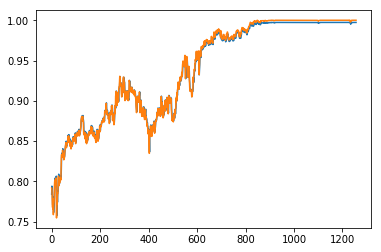

In [15]:

#print(closed_X_val.shape,Volume_X_val.shape,ema6_X_val.shape,ema12_X_val.shape,ema26_X_val.shape,macd_X_val.shape,wrsi_X_val.shape,K_X_val.shape,D_X_val.shape)
preds = merged_model.predict([Volume_X_val,ema6_X_val,ema12_X_val,ema26_X_val,macd_X_val,wrsi_X_val,K_X_val,D_X_val,closed_X_val])
r2score = r2_score(closed_Y_val,preds[8])
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))
plt.plot(preds[8])
plt.plot(closed_Y_val)
plt.show()

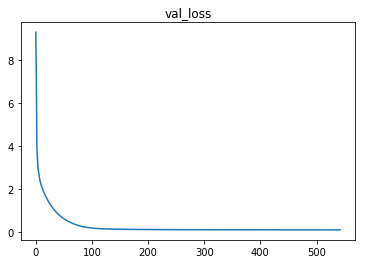

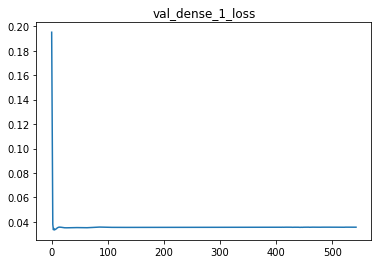

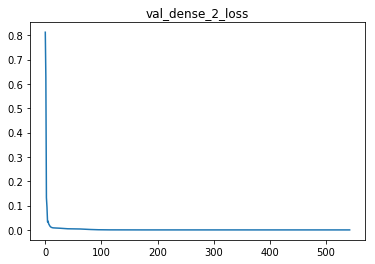

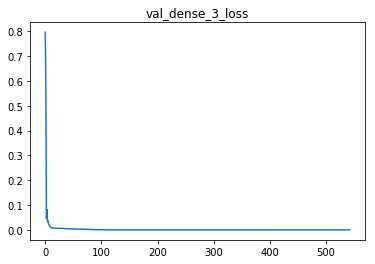

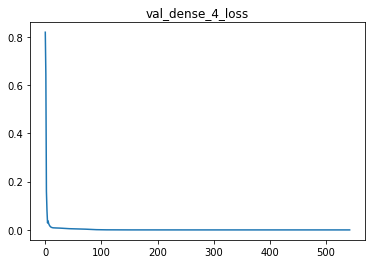

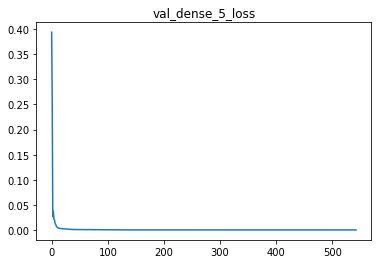

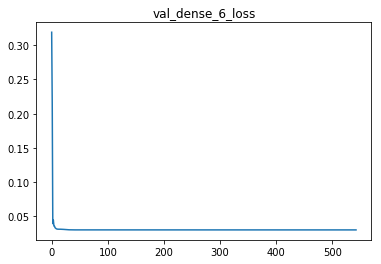

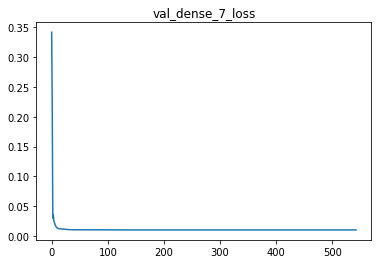

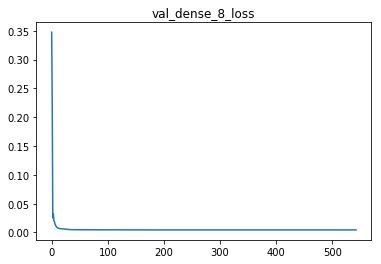

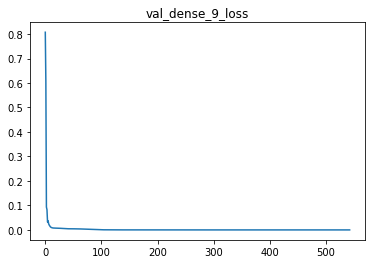

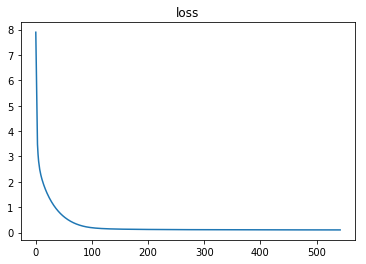

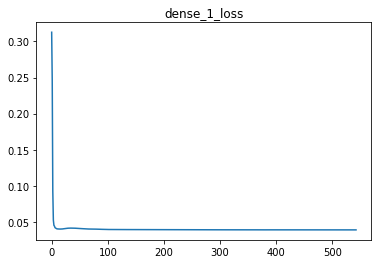

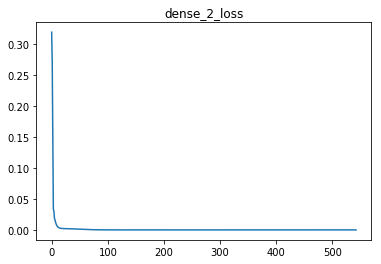

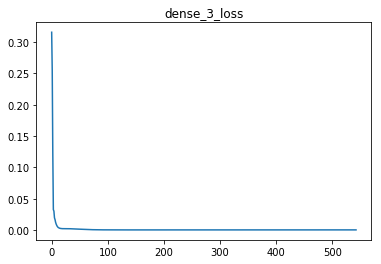

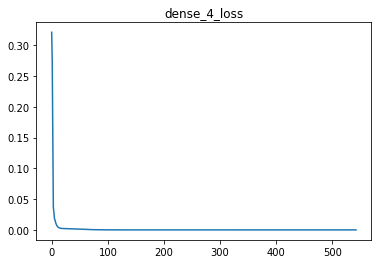

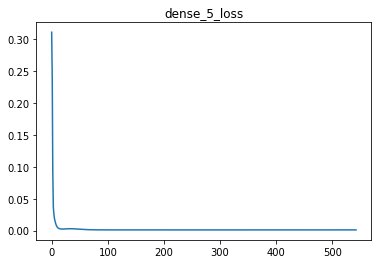

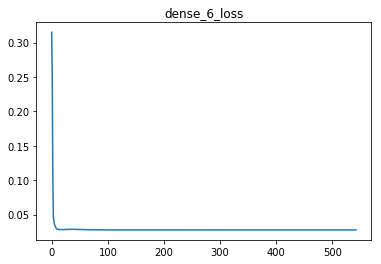

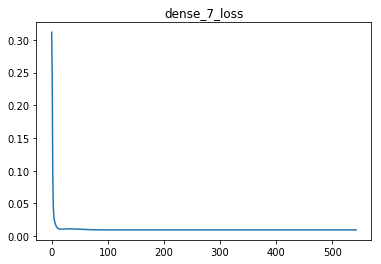

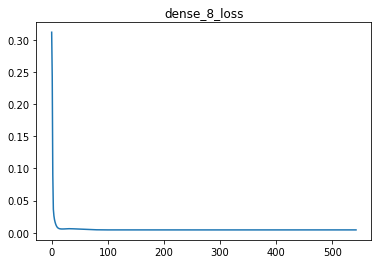

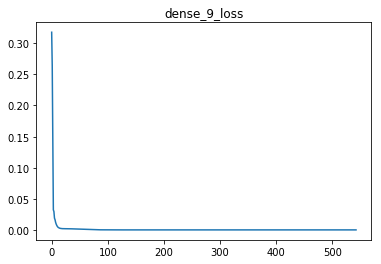

In [16]:

his = history.history
for k in his.keys():
    plt.title(k)
    plt.plot(his[k])
    plt.show()

[[0.7842369 ]
 [0.79414415]
 [0.7916681 ]
 [0.7842369 ]
 [0.77084744]]
[[0.7842369  0.34880295 0.34880295 ... 0.34880295 0.34880295 0.34880295]
 [0.79414415 0.5936536  0.5936536  ... 0.5936536  0.5936536  0.5936536 ]
 [0.7916681  0.35207608 0.35207608 ... 0.35207608 0.35207608 0.35207608]
 ...
 [0.99729264 0.4166635  0.4166635  ... 0.4166635  0.4166635  0.4166635 ]
 [0.99729264 0.3994371  0.3994371  ... 0.3994371  0.3994371  0.3994371 ]
 [0.99729264 0.34439126 0.34439126 ... 0.34439126 0.34439126 0.34439126]]


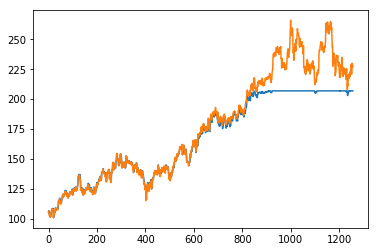

In [74]:
tmp = np.array(preds).reshape(1257,9)[-1]
tt = preds
tmp = np.array(tt[-1]).reshape(1257,1)
for i in range(0,len(preds)-1):
    tt[i+1] = np.array(tt[i]).reshape(1257,1)
tt[0] = tmp
#tt = np.array(tt).reshape(1257,9)
#print(tt.shape)
print(preds[0][0:5])
print(np.array(tt).T.reshape(1257,9))
tt = np.array(tt).T.reshape(1257,9)
t = pd.DataFrame(data=sc_X.inverse_transform(tt))
#plt.plot(pd.DataFrame(X_val).loc[1:,0])
plt.plot(t.loc[:,0].values)
plt.plot(pd.DataFrame(X_val).loc[1:,0].values)
plt.show()